# Paddy disease classification
Kaggle competition
https://www.kaggle.com/competitions/paddy-disease-classification

### Setting up env and downloading data from kaggle

In [1]:
import os

if os.getenv("COLAB_RELEASE_TAG"):
  colab_flag = True
else:
  colab_flag = False

if colab_flag == True:
   print("Running in Colab...")
   #Install Kaggle API
   ! pip install -q kaggle
   #Install Huggingface Datasets lib
   ! pip install -q datasets
   #Install Huggingface transformers & the sentencepiece
   ! pip install -q transformers[sentencepiece,torch]
   #Intall Timm for Pytorch Image Models
   ! pip install -q timm
   print("...Installed required dependencies")
else:
   print("Assuming running in local environment...")

Running in Colab...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 10.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 31.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 64.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 66.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.4 MB/s eta 0:00:00
...Installed required dependencies


In [2]:
if colab_flag == True:
  import json
  from google.colab import drive
  drive.mount('/content/drive/')

  # Set the file path
  file_path = '/content/drive/MyDrive/dtu/fastAI/04_NLP/kaggle_api.json'

  # Check if the file exists
  if os.path.exists(file_path):
      # Load the JSON file
      with open(file_path) as f:
          creds = json.load(f)
      print('Sucesfully set kaggle credentials')
  else:
      # Handle the case when the file does not exist
      creds = None  # or any other appropriate action you want to take
      print('Error: File not found, Credentials NOT set')
else:
    import json
    file_path = "../secrets/kaggle_api.json"
    # Check if the file exists
    if os.path.exists(file_path):
        # Load the JSON file
        with open(file_path) as f:
            creds = json.load(f)
        print('Sucesfully set kaggle credentials')
    else:
        # Handle the case when the file does not exist
        creds = None  # or any other appropriate action you want to take
        print('Error: File not found, Credentials NOT set')

Mounted at /content/drive/
Sucesfully set kaggle credentials


In [6]:
#using `pathlib.Path to work with paths in Python`
from pathlib import Path
#Set path for the titanic dataset
path = Path('paddy-disease-classification')

if path.exists():
  print('Data folder exists')
else:
  print('Data not detected, starting download')
  #Setup of kaggle credentials to use the API for downloading dataset
  cred_path = Path('~/.kaggle/kaggle.json').expanduser()
  if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(json.dumps(creds))
    #If not Json
    #cred_path.write_text(creds)
    cred_path.chmod(0o600)
  import zipfile,kaggle
  #Download data
  kaggle.api.competition_download_cli(str(path))
  #Unzip at path
  zipfile.ZipFile(f'{path}.zip').extractall(path)

#Verifying the the local content
!ls {path}

Data folder exists
sample_submission.csv  test_images  train.csv  train_images


### Inspecting the data

In [7]:
from fastai.vision.all import *
set_seed(42)

train_path = path/'train_images'
files = get_image_files(train_path)

In [5]:
#Simply contains the filename of all the images in the given folder
files[0:3]

(#3) [Path('paddy-disease-classification/train_images/brown_spot/104426.jpg'),Path('paddy-disease-classification/train_images/brown_spot/102296.jpg'),Path('paddy-disease-classification/train_images/brown_spot/100854.jpg')]

### WARNING! Image size: 480x640 or 640x480 ??
Images need to be resized to same dimension for the ML model to process.


**OBS for dimensions!!** If you request different library you might get different response.
- In "image world" (PIL), Columns by Rows (if using img.size, .shape will return rows by columns)
- Pytorch, returns Rows by Columns

Size according to PIL image: (480, 640)
Shape according to PIL image: (640, 480)
Shape according to torch, tensor: torch.Size([640, 480, 3])


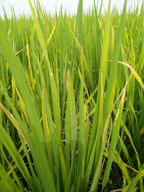

In [6]:
img = PILImage.create(files[5])
print(f'Size according to PIL image: {img.size}')
print(f'Shape according to PIL image: {img.shape}')
#Convert to tensor
img_t = tensor(img)
print(f'Shape according to torch, tensor: {img_t.shape}')
img.to_thumb(192)

Checking the image size is suprisingly slow process, hence we do it in parallel to speed up.

In [13]:
import multiprocessing

n_cores = multiprocessing.cpu_count()
print(n_cores)

16


In [8]:
from fastcore.parallel import *

def check_size(img):
    return PILImage.create(img).size

sizes = parallel(check_size, files, n_workers=n_cores)
pd.Series(sizes).value_counts()

(480, 640)    10403
(640, 480)        4
dtype: int64

Observing that a few are out of size, hence we have to resize our images.

**Resizing: You want to do this on a GPU**
- Colab runtime: 6 seconds
- Local CPU runtime: 1 min 20 seconds

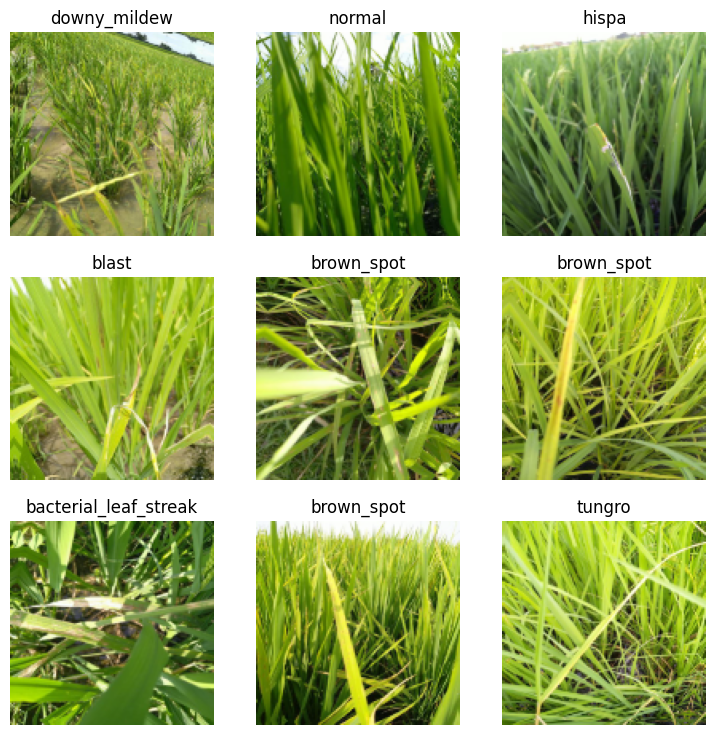

In [11]:
dls = ImageDataLoaders.from_folder(train_path,
                                        valid_pct=0.2,
                                        seed=42,
                                        item_tfms=Resize(480, method='squish'),
                                        #Data augmentation done on GPU, transformations of the data taking
                                        #a subset of the image (128) and applying random transformations
                                        batch_tfms=aug_transforms(size=128, min_scale=0.75))

dls.show_batch()

### The first model
Best models for finetuning, 100 different models, evaluated on the Pets dataset and a sattelite imagedataset (Planet): https://www.kaggle.com/code/jhoward/the-best-vision-models-for-fine-tuning . **One year old**

To begin with, choose decent accuracy but FAST model = Resnet26d


In [12]:
learn = vision_learner(dls, 'resnet26d', metrics=error_rate, path='.').to_fp16()

Find LR timing:
- Colab: 1 min
- Local CPU: 3 min 46 sec

SuggestedLRs(valley=0.0012022644514217973, slide=0.00363078061491251)

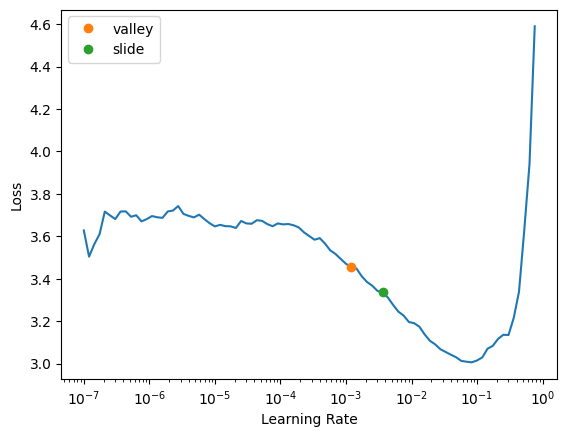

In [13]:
learn.lr_find(suggest_funcs=(valley, slide))

Generally speaking the reccomendations from fastAI is conservative to be on the safe side, so typically one can select a higher LR to speed up the process, as long as one is not too close at the party where LR is too high and we end up overstepping.

In [14]:
#3 epochs, LR= 10^-2
learn.fine_tune(3, 0.01)

epoch,train_loss,valid_loss,error_rate,time
0,1.764797,1.196823,0.387314,02:07


epoch,train_loss,valid_loss,error_rate,time
0,1.134574,0.797982,0.263815,01:59
1,0.778791,0.509714,0.165786,01:59
2,0.557785,0.414981,0.129265,01:57


Took 8 min to finetune on colab, quite a bit longer than the 1 min it took in Jeremys tutorial.

### Saving the model

In [17]:
learn.save("/content/drive/MyDrive/dtu/fastAI/06_Paddy_vision/models")

Path('/content/drive/MyDrive/dtu/fastAI/06_Paddy_vision/models.pth')

In [12]:
doc(Learner.save)